## Load Data
Load the MNIST data, which comes pre-loaded with TensorFlow.

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_, y_ = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_, y_, test_size=0.20, random_state=42)

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))



Image Shape: (32, 32, 3)

Training Set:   31367 samples
Validation Set: 7842 samples
Test Set:       12630 samples


1


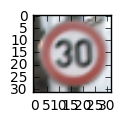

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [5]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [6]:
import tensorflow as tf

EPOCHS = 25
BATCH_SIZE = 128

In [7]:
from tensorflow.contrib.layers import flatten

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

def conv2d(data, weight):
    return tf.nn.depthwise_conv2d_native(data,weight,strides=[1, 1, 1, 1],padding='VALID')    

def max_pool(data):
    return tf.nn.max_pool(data, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #rgb_to_grayscale
    x = tf.image.rgb_to_grayscale(x, name='grayscale')

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    #out_height = ceil(float(32 - 5 + 1) / float(1)) = 28
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 5), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(5))
    conv1   = tf.nn.bias_add(conv2d(x, conv1_W), conv1_b)
    print (conv1)

    #Activation.
    conv1 = tf.nn.relu(conv1)

    #Pooling. Input = 28x28x6. Output = 14x14x6.
    #out_height = ceil(float(28 - 2 + 1) / float(2)) =  ceil(13.5) = 14
    conv1 = max_pool(conv1)

    #Layer 2: Convolutional. 1Input = 14x14x6 Output = 10x10x16.
    #out_height = ceil(float(14 - 5 + 1) / float(1)) = 10
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 5, 7), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(35))
    #conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    #conv3 = tf.nn.depthwise_conv2d_native(data,weight,strides=[1, 1, 1, 1],padding='VALID') 
    conv2   = conv2d(conv1, conv2_W)+conv2_b
    print (conv2)
    #Activation.
    conv2 = tf.nn.relu(conv2)

    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = max_pool(conv2)

    #Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(875, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Activation.
    fc1    = tf.nn.relu(fc1)

    #Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #Activation.
    fc2    = tf.nn.relu(fc2)

    #Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.
`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline

In [9]:
rate = 0.0003

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Tensor("BiasAdd:0", shape=(?, 28, 28, 5), dtype=float32)
Tensor("add:0", shape=(?, 10, 10, 35), dtype=float32)


## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model

In [11]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.616

EPOCH 2 ...
Validation Accuracy = 0.824

EPOCH 3 ...
Validation Accuracy = 0.885

EPOCH 4 ...
Validation Accuracy = 0.912

EPOCH 5 ...
Validation Accuracy = 0.935

EPOCH 6 ...
Validation Accuracy = 0.944

EPOCH 7 ...
Validation Accuracy = 0.943

EPOCH 8 ...
Validation Accuracy = 0.956

EPOCH 9 ...
Validation Accuracy = 0.955

EPOCH 10 ...
Validation Accuracy = 0.961

EPOCH 11 ...
Validation Accuracy = 0.964

EPOCH 12 ...
Validation Accuracy = 0.967

EPOCH 13 ...
Validation Accuracy = 0.962

EPOCH 14 ...
Validation Accuracy = 0.967

EPOCH 15 ...
Validation Accuracy = 0.970

EPOCH 16 ...
Validation Accuracy = 0.963

EPOCH 17 ...
Validation Accuracy = 0.974

EPOCH 18 ...
Validation Accuracy = 0.969

EPOCH 19 ...
Validation Accuracy = 0.964

EPOCH 20 ...
Validation Accuracy = 0.977

EPOCH 21 ...
Validation Accuracy = 0.971

EPOCH 22 ...
Validation Accuracy = 0.974

EPOCH 23 ...
Validation Accuracy = 0.976

EPOCH 24 ...
Validation Accura